结果将保存至：/root/autodl-tmp/图像处理/GMM clustering results
EDS图像尺寸：(768, 1024, 3)

6个聚类中心的RGB值：
类别0：RGB(124, 71, 25)
类别1：RGB(36, 21, 8)
类别2：RGB(84, 17, 91)
类别3：RGB(95, 52, 21)
类别4：RGB(149, 20, 10)
类别5：RGB(64, 36, 14)
已生成类别0的物相掩模
已生成类别1的物相掩模
已生成类别2的物相掩模
已生成类别3的物相掩模
已生成类别4的物相掩模
已生成类别5的物相掩模

所有结果已保存完成！
- 聚类彩色图：/root/autodl-tmp/图像处理/GMM clustering results/GMM_result.jpg
- 物相掩模：共6个，路径：/root/autodl-tmp/图像处理/GMM clustering results/mask_1.jpg ~ mask_6.jpg


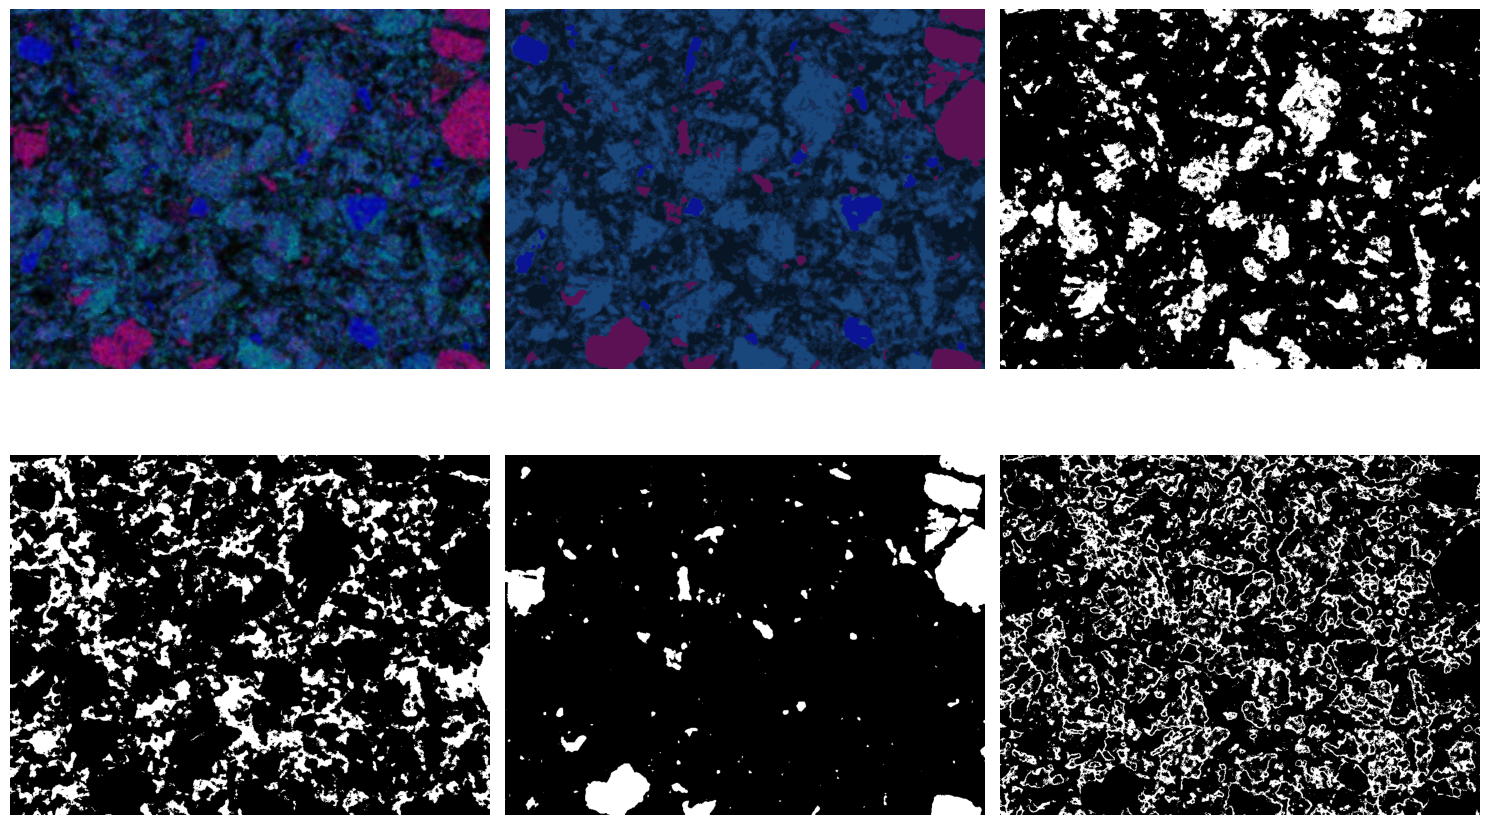

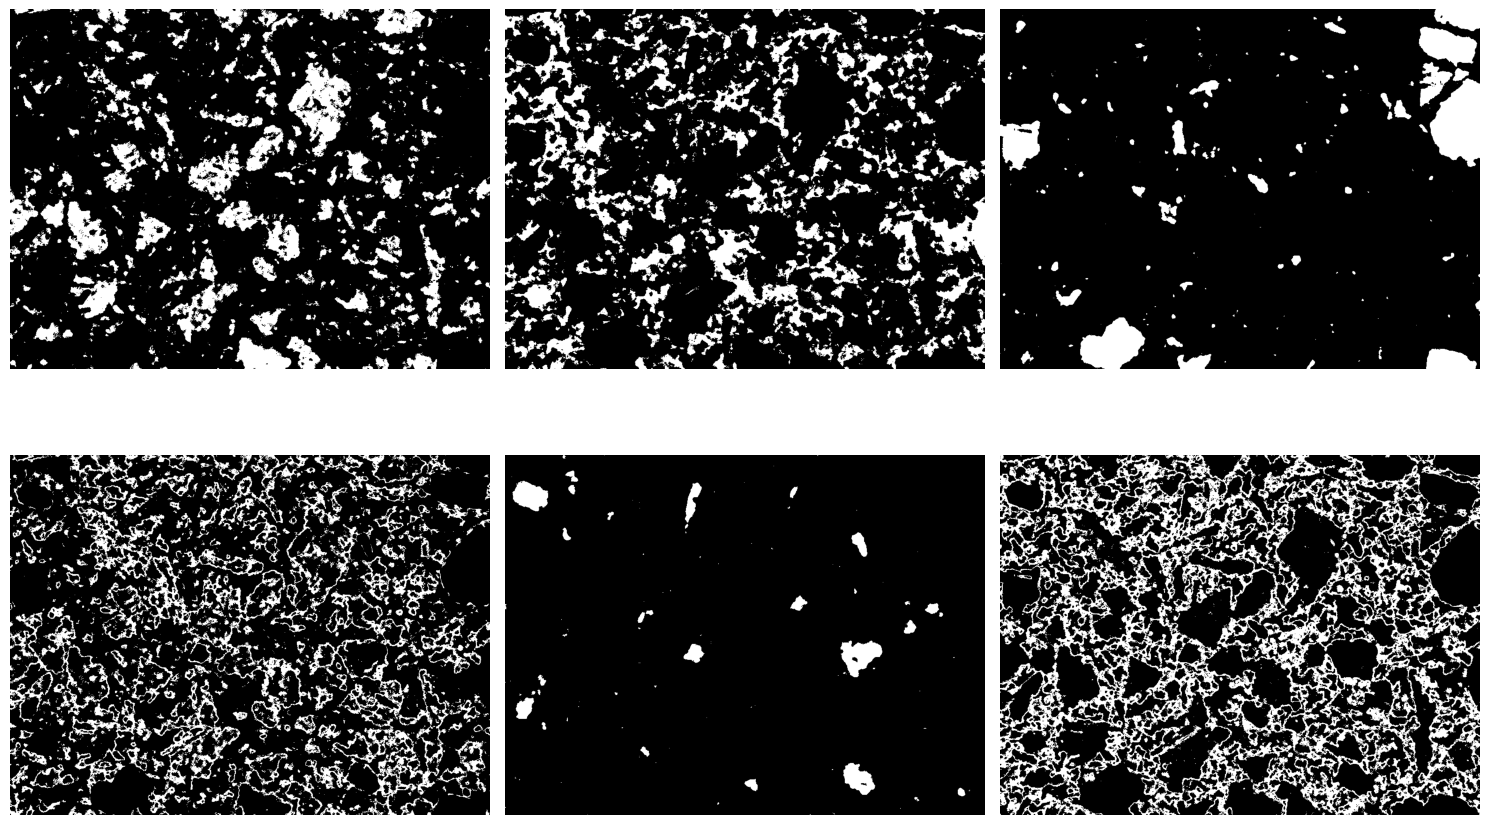

In [5]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import os  # 用于创建文件夹和路径处理

# -------------------------- 1. 核心参数配置（根据实际情况修改） --------------------------
INPUT_EDS_PATH = "Composite.jpg"
CLUSTER_NUM = 6
RESULT_FOLDER = "GMM clustering results"

# -------------------------- 2. 自动创建结果文件夹 --------------------------
current_dir = os.getcwd()
result_folder_path = os.path.join(current_dir, RESULT_FOLDER)
os.makedirs(result_folder_path, exist_ok=True)
print(f"结果将保存至：{result_folder_path}")

# -------------------------- 3. 读取复合EDS彩色图像 --------------------------
composite_EDS = cv2.imread(INPUT_EDS_PATH, cv2.IMREAD_UNCHANGED)
if composite_EDS is None:
    raise FileNotFoundError(f"未找到输入图像，请检查路径：{INPUT_EDS_PATH}\n建议：将图像放在当前代码运行的目录下，或写全图像路径（如'E:/test/Composite.jpg'）")

print(f"EDS图像尺寸：{composite_EDS.shape}")  # 例如 (896, 1024, 3)，高度896，宽度1024

# -------------------------- 4. GMM聚类数据预处理 --------------------------
EDS_gmm = composite_EDS.reshape(-1, 3)

# -------------------------- 5. 执行GMM聚类 --------------------------
gmm = GaussianMixture(
    n_components=CLUSTER_NUM,
    covariance_type='full',
    init_params='kmeans',
    random_state=0
)
gmm.fit(EDS_gmm)
target = gmm.predict(EDS_gmm)
cluster_centers = np.uint8(gmm.means_)
print(f"\n{CLUSTER_NUM}个聚类中心的RGB值：")
for i, center in enumerate(cluster_centers):
    print(f"类别{i}：RGB({center[0]}, {center[1]}, {center[2]})")

# -------------------------- 6. 生成聚类结果图像 --------------------------
gmm_result = cluster_centers[target.flatten()]
gmm_res_image = gmm_result.reshape(composite_EDS.shape)  # 尺寸与原始图一致：(896, 1024, 3)

# -------------------------- 7. 提取每个类别的物相掩模 --------------------------
masks = []
for i in range(CLUSTER_NUM):
    lower_bound = cluster_centers[i]
    upper_bound = cluster_centers[i]
    mask = cv2.inRange(gmm_res_image, lower_bound, upper_bound)
    masks.append(mask)
    print(f"已生成类别{i}的物相掩模")

# -------------------------- 8. 保存结果文件 --------------------------
gmm_res_save_path = os.path.join(result_folder_path, "GMM_result.jpg")
cv2.imwrite(gmm_res_save_path, gmm_res_image)
for i, mask in enumerate(masks):
    mask_save_path = os.path.join(result_folder_path, f"mask_{i+1}.jpg")
    cv2.imwrite(mask_save_path, mask)

print(f"\n所有结果已保存完成！")
print(f"- 聚类彩色图：{gmm_res_save_path}")
print(f"- 物相掩模：共{CLUSTER_NUM}个，路径：{result_folder_path}/mask_1.jpg ~ mask_{CLUSTER_NUM}.jpg")

# -------------------------- 9. 展示结果图像 --------------------------
# 设置中文字体（可选，如果需要显示中文标题）
plt.rcParams['axes.unicode_minus'] = False

# 创建子图显示原图和聚类结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 显示原始图像
axes[0, 0].imshow(cv2.cvtColor(composite_EDS, cv2.COLOR_BGR2RGB))
axes[0, 0].axis('off')

# 显示聚类结果
axes[0, 1].imshow(cv2.cvtColor(gmm_res_image, cv2.COLOR_BGR2RGB))
axes[0, 1].axis('off')

# 显示前4个掩模
for i in range(min(4, CLUSTER_NUM)):
    row = (i + 2) // 3
    col = (i + 2) % 3
    if row < 2:
        axes[row, col].imshow(masks[i], cmap='gray')
        axes[row, col].axis('off')

# 隐藏多余的子图
for i in range(min(4, CLUSTER_NUM) + 2, 6):
    row = i // 3
    col = i % 3
    if row < 2:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 如果要显示所有掩模，可以单独创建一个图
if CLUSTER_NUM > 4:
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(CLUSTER_NUM):
        row = i // 3
        col = i % 3
        if row < 2:
            axes2[row, col].imshow(masks[i], cmap='gray')
            axes2[row, col].axis('off')
    
    # 隐藏多余的子图
    for i in range(CLUSTER_NUM, 6):
        row = i // 3
        col = i % 3
        if row < 2:
            axes2[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
